In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)


In [2]:
# Define num_qubits, the number of qubits, for the rest of the Lab
num_qubits = 5

# Load the dictionary 
birds_dataset = pd.read_csv(r"C:\Users\Rajat\Downloads\birds_dataset.csv") 

# Check if the dataset is loaded correctly - coefficients should be complex numbers
for i in range(2**num_qubits):
    key = 'c%.0f' %i
    birds_dataset[key] = birds_dataset[key].astype(np.complex128)

# Print the dataset
birds_dataset

,names,c0,c1,c2,c3,c4,c5,c6,c7,c8,...,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31
0,Falcon,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j
1,Hummingbird,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j
2,Eagle,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,Osprey,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,Heron,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
5,Peacock,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
6,Parrot,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
7,Swan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
8,Toucan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
9,Cardinal,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j


In [3]:
list_coefficients=[]
list_labels=[]

for i in range (10):
    amplitude_state=[]
    if i<5:
        list_labels.append(1)
    else:
        list_labels.append(0)
    for j in range(2**num_qubits):
        key = 'c%.0f' %j
        amplitude_state.append(birds_dataset[key][i])
    list_coefficients.append(amplitude_state)

Amplitude Emnedding using qc.initialize()

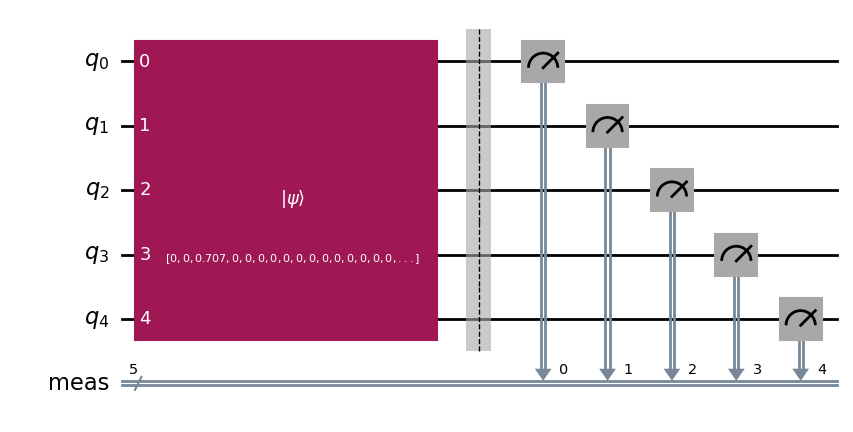

In [4]:
index_bird=2 
amplitudes=list_coefficients[index_bird]

qc=QuantumCircuit(5)
qc.initialize(amplitudes,range(num_qubits))
qc.measure_all()

qc.draw(output="mpl")

Choosing the right ansatz that allows us to converge to the desired solution is not an easy problem. In general, there are a few trade-offs to consider:

* Speed: By reducing the search space, and thus the number of gates and the depth of the ansatz, the algorithm can run faster.

* Accuracy: Reducing the search space could risk excluding the actual solution to the problem, leading to suboptimal solutions.

* Noise: Deeper circuits are affected by noise, so we need to experiment with our ansatz's connectivity, gates, and gate fidelity.

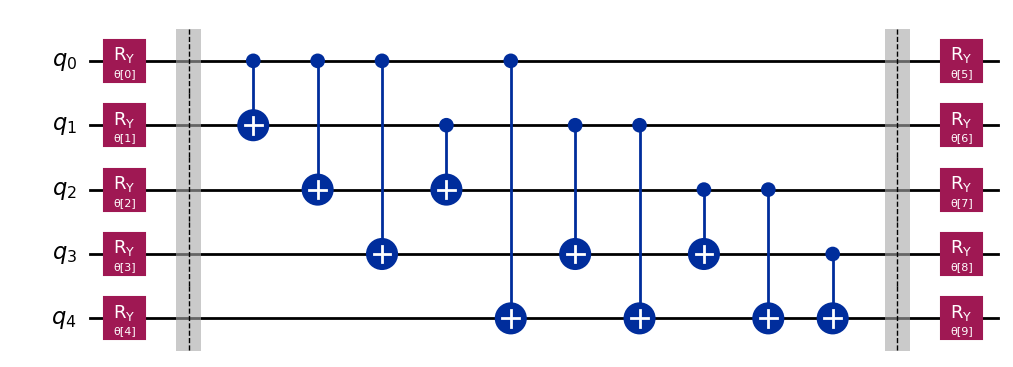

In [6]:
num_qubits=5
reps=1
entanglement="full"

ansatz=RealAmplitudes(num_qubits,reps=reps,entanglement=entanglement,insert_barriers=True)

ansatz.decompose(reps=1).draw(output="mpl")

In [7]:
obs=SparsePauliOp("ZZZZZ")
estimator=StatevectorEstimator()

pm=generate_preset_pass_manager(backend=AerSimulator(),optimization_level=3,
                                seed_transpiler=0)

In [8]:
def cost_function(params,list_coefficients,list_labels,obs,estimator,pm,callback_dict):
    cost=0 
    for amplitudes,label in zip(list_coefficients,list_labels):
        qc=QuantumCircuit(num_qubits)
        qc.initialize(amplitudes)
        classifier=qc.compose(ansatz)
        transpiled_classifier=pm.run(classifier)

        transpiled_obs=obs.apply_layout(layout=transpiled_classifier.layout)

        pub=(transpiled_classifier,transpiled_obs,params)
        job=estimator.run([pub])
        result=job.result()[0]

        cost+=np.abs(result-label)

    callback_dict["iters"]+=1
    callback_dict["prev_vector"]=params 
    callback_dict["cost_history"].append(cost)

    print(
        "Iters. done: {} [Current Cost:{}]".format(callback_dict["iters"],cost),
        end="\r",
        flush=True
    )
    return cost

In [12]:
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    
    return cost

Classical Post Processing Stage

In [13]:
cost_history_list = []
res_list = []

# Retrieve the initial parameters
params_0_list = np.load(r"C:\Users\Rajat\Downloads\params_0_list.npy")

for it, params_0 in enumerate(params_0_list):

    print('Iteration number: ', it)
    
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func, 
        params_0, 
        args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations
    
    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

Iteration number:  0
 message: Optimization terminated successfully.95]]
 success: True
  status: 1
     fun: 4.090375126829395
       x: [ 3.657e+00 -2.208e-01  9.172e-02  3.716e+00  4.940e+00
            1.571e+00 -1.635e-04  5.966e+00  2.511e+00  3.028e+00]
    nfev: 178
   maxcv: 0.0
Iteration number:  1
 message: Optimization terminated successfully.95]]
 success: True
  status: 1
     fun: 4.999807985582195
       x: [ 9.885e-03 -8.996e-05  3.370e-01 -3.625e-01  1.870e+00
            6.793e-01  1.563e+00  1.191e+00  1.087e+00 -9.877e-02]
    nfev: 126
   maxcv: 0.0
Iteration number:  2
 message: Optimization terminated successfully.5]]]
 success: True
  status: 1
     fun: 4.10363534160955
       x: [ 4.068e+00  3.133e+00  3.216e+00  3.408e+00  1.022e+00
            2.303e+00  3.106e+00  3.060e+00  3.194e+00  2.569e+00]
    nfev: 142
   maxcv: 0.0
Iteration number:  3
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.04067

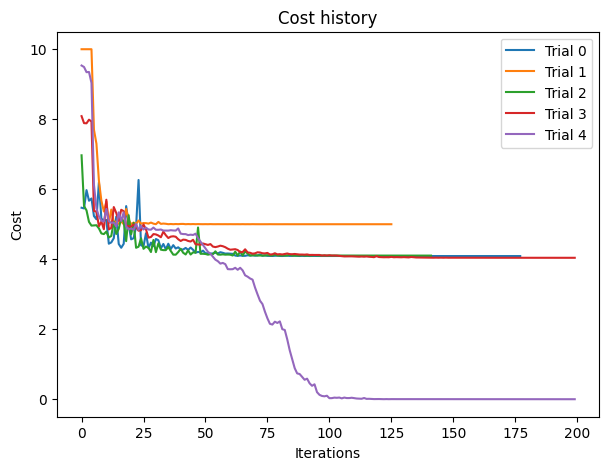

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost history')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
### Write your code below here ###
#np.save('res_list.npy', res_list)

for it, cost_history in enumerate(cost_history_list):
    ax.plot(cost_history, label='Trial '+str(it))
    ax.legend()

In [16]:
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        list: List of test results
    """
    ### Write your code below here ###
    results_test = []
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        qc.initialize(amplitudes)
        classifier = qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        pub = (transpiled_classifier, obs, opt_params)
        job = estimator.run([pub])
        result = job.result()[0].data.evs
        results_test.append(abs(result))
    ### Don't change any code past this line ###                                 
    return results_test

In [17]:
def compute_performance(result_list, list_labels):
    
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        float: Performance of the classifier
    """
    ### Write your code below here ###
    performance = 100
    for result, label in zip(result_list, list_labels):
        performance -= np.abs(abs(result) - label)/len(list_coefficients)*100
    ### Don't change any code past this line ###                                    
    return performance

Performance for trial 0: 72.47823128278361
Performance for trial 1: 50.06915567529158
Performance for trial 2: 71.11818706304385
Performance for trial 3: 78.59989333150547
Performance for trial 4: 99.99998417573303


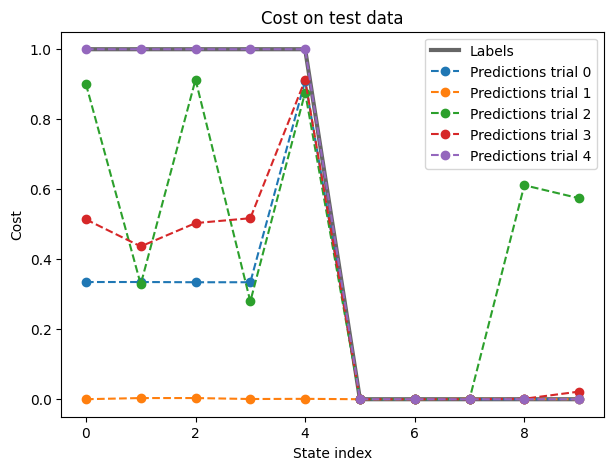

In [18]:

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

for index in range(len(res_list)):
    opt_params = res_list[index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)
    print(f"Performance for trial {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

ax.legend()

**Impact of noise on the performance of the VQC**

In this part of the Lab, we focus on local testing, meaning that we are going to simulate quantum noise on our local machine. For this reason, we will create a custom fake backend. But first, let’s talk a bit about different types of quantum noise:

* Decoherence: Qubits will lose their information of the quantum state over time, especially if they stay idle after they are initialized. For decoherence we normally don't use an error rate, but instead use T1 and T2 time, the amount of time it takes until a qubit loses its information.


* Measurement Errors: Measuring qubits can cause errors, meaning that instead of a 0, a 1 is measured, and vice versa. This works similar to a classical channel.

* Gate Errors: Gates are not perfect and have a small chance to introduce an error when applied. This is especially true for two-qubit gates, like the CX, the CZ, or the ECR gate, which normally have roughly a 10x higher error rate than single-qubit gates.


* Crosstalk Errors: When applying a gate to a qubit, other qubits, especially neighboring ones, can also be influenced. This is even the case if these qubits lie idle. Fortunately, on the newest Heron devices, this is less of a problem, but it is still something to be aware of.

In [28]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
fake_backend=AerSimulator()

In [31]:

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

In [32]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

In [33]:
error_rates = {
  "default_duration": 1e-8,
  "rz_error": 1e-8,
  "x_error": 1e-8,
  "sx_error": 1e-8,
  "measure_error": 1e-8,
  "cx_error": 1e-8
}

update_error_rate(fake_backend, error_rates)

In [37]:
best_result_index = 4

Performance for run 4: 50.2392578125
Performance for run 4: 58.4375
Performance for run 4: 91.298828125
Performance for run 4: 98.095703125


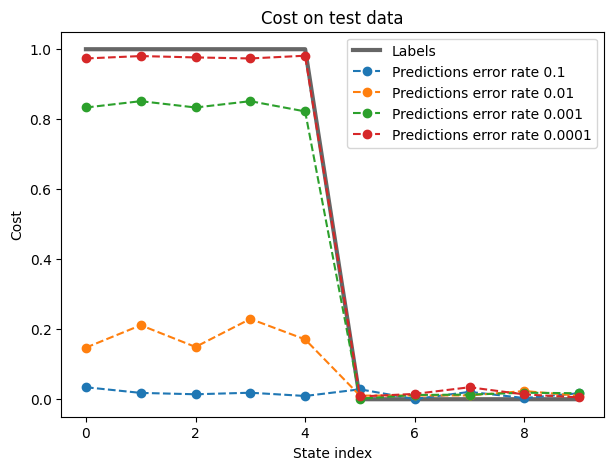

In [38]:

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

error_rate_list = [1e-1, 1e-2, 1e-3, 1e-4]

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

for error_rate_value in error_rate_list:

    ### Write your code below here ###
    error_rates = {
      "default_duration": 1e-8,
      "rz_error": error_rate_value,
      "x_error": 1e-8,
      "sx_error": 1e-8,
      "measure_error": 1e-8,
      "cx_error": error_rate_value
    }

    update_error_rate(fake_backend, error_rates)
    estimator = Estimator(mode=fake_backend)
    pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

    opt_params = res_list[best_result_index].x
    ### Don't change any code past this line ###  
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)

    print(f"Performance for run {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions error rate '+str(error_rate_value))
    
ax.legend()

In [39]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

Depth of two-qubit gates:  31


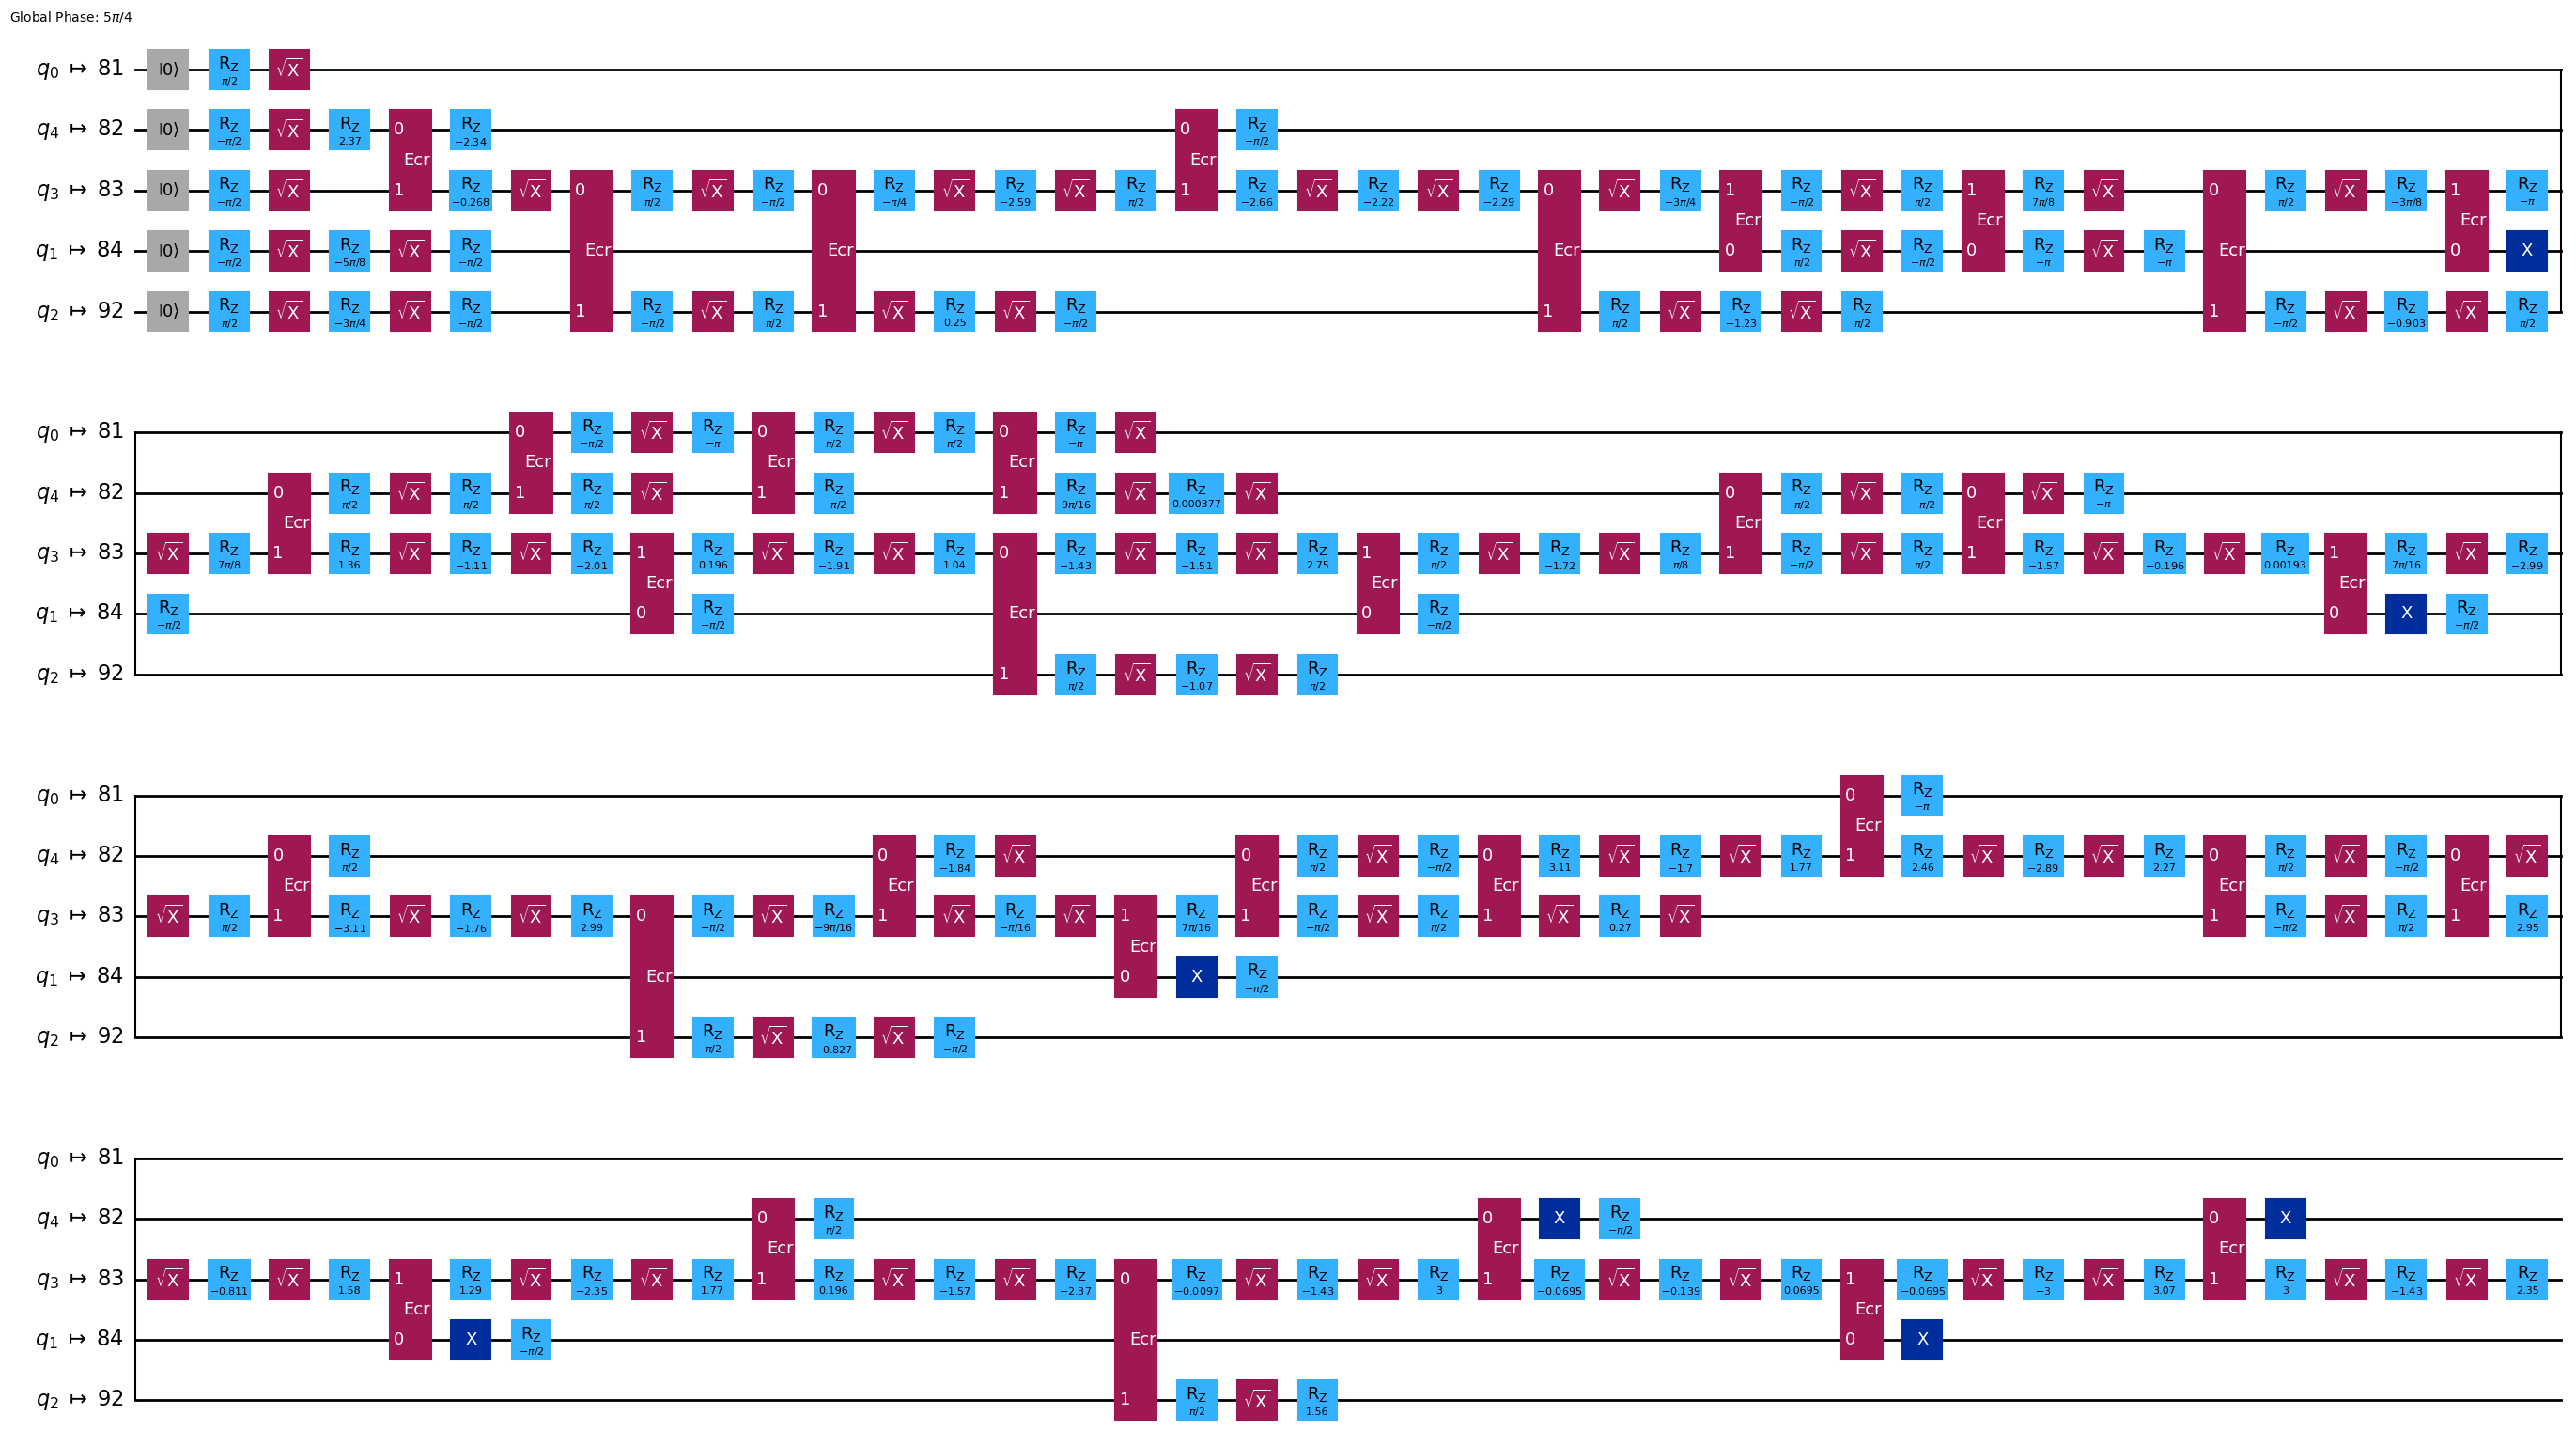

In [40]:
index_bird = 0 #you can check different birds by changing the index
qc = QuantumCircuit(num_qubits)
qc.initialize(list_coefficients[index_bird])
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", idle_wires=False, fold=40)


This circuit is too deep to be run on real quantum hardware! Let's try to find a different way to map the states of the datase

In [41]:
print(transpiled_qc.depth())

159


In [42]:
def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
            
    ### Write your code below here ###
    def generate_binary(qc, number):
        position=0
        bit=1
        while number >= bit:
            if number & bit:
                qc.x(position)
            bit <<= 1
            position=position+1

    qc = QuantumCircuit(num_qubits)
    if bird_index < 5:
        generate_GHZ(qc)
    generate_binary(qc, bird_index)
    ### Don't change any code past this line ###
    return qc

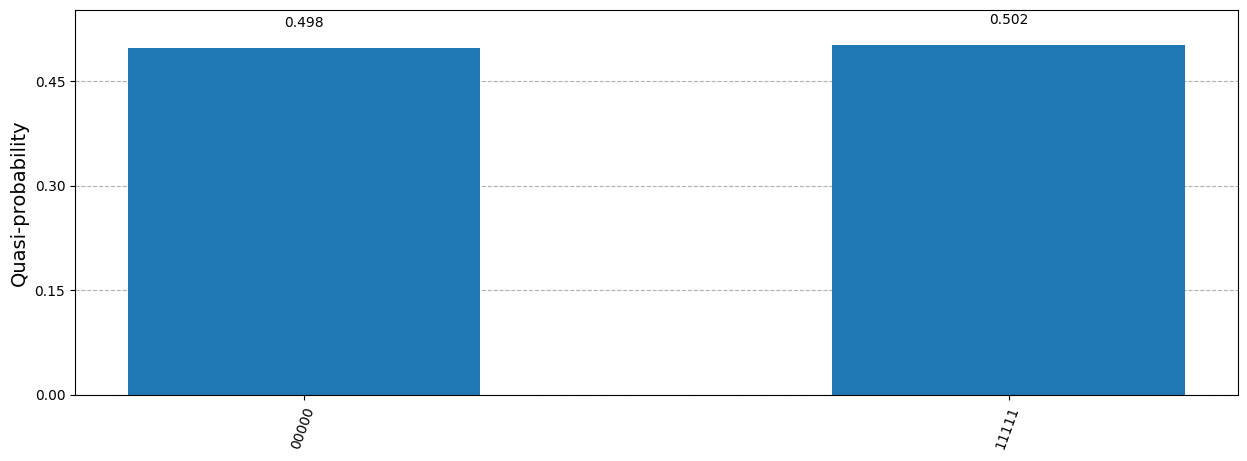

In [44]:
index_bird = 0 # You can check different birds by changing the index

# Build the amplitude embedding 
qc = amplitude_embedding(num_qubits, index_bird)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(mode=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(15, 5))

Depth of two-qubit gates:  4


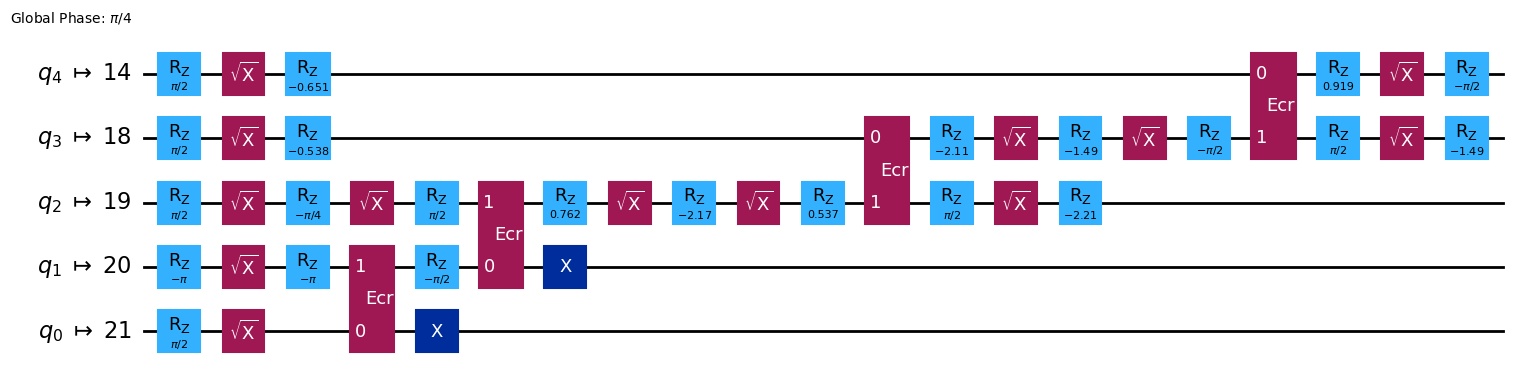

In [45]:

index_bird = 0 #You can check different birds by changing the index
qc = amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth of two-qubit gates:  18


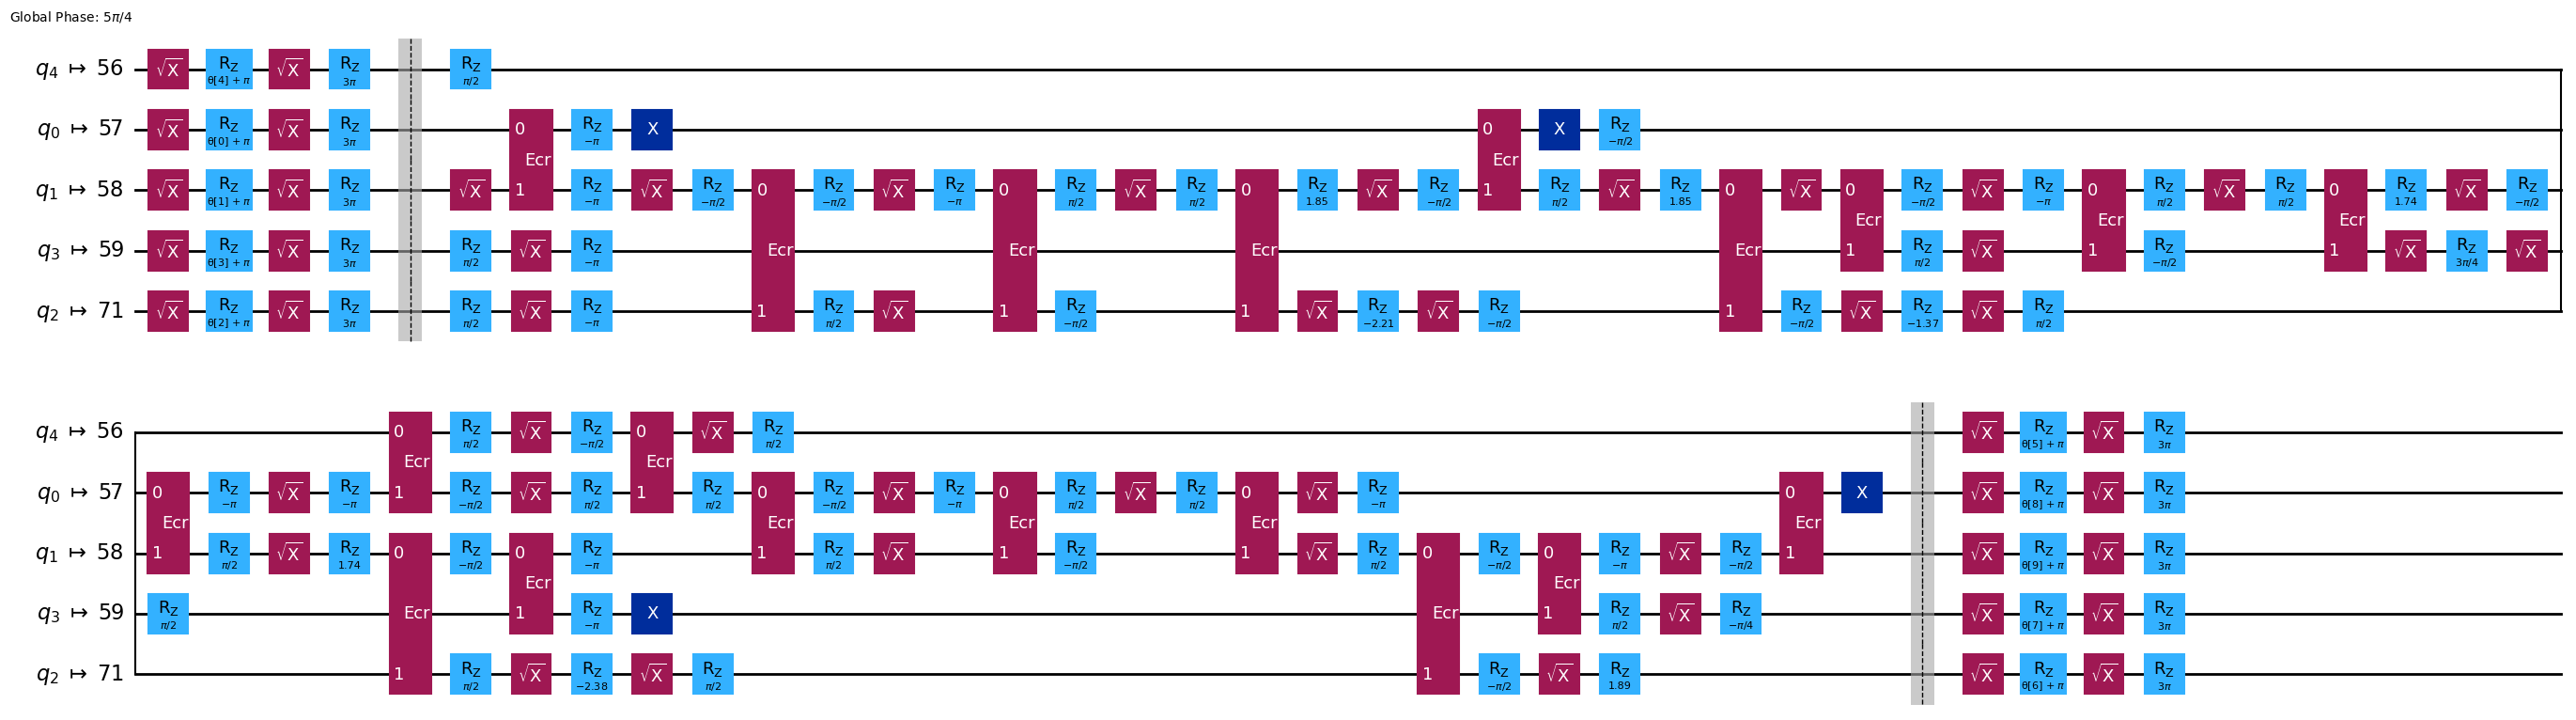

In [46]:

old_ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='full', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(old_ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

Depth of two-qubit gates:  2


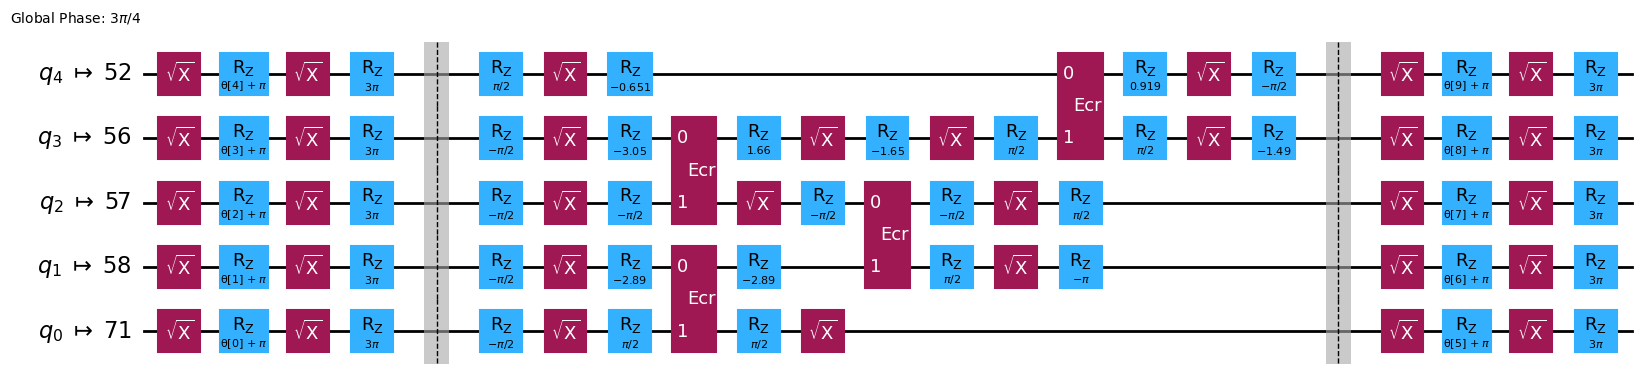

In [47]:
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='pairwise', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(ansatz)
### Don't change any code past this line ###

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", fold=False, idle_wires=False)

In [48]:
old_mapping = QuantumCircuit(num_qubits)
old_mapping.initialize(list_coefficients[index_bird])
old_classifier = old_mapping.compose(old_ansatz)

new_mapping = amplitude_embedding(num_qubits, index_bird)
new_classifier = new_mapping.compose(ansatz)

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
old_transpiled_classifier = pm.run(old_classifier)
new_transpiled_classifier = pm.run(new_classifier)

print('Old depth of two-qubit gates: ', old_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))
print('Current depth of two-qubit gates: ', new_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))

Old depth of two-qubit gates:  49
Current depth of two-qubit gates:  6


In [49]:
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """
    ### Write your code below here ###
    results_test = []
    for bird, label in enumerate(list_labels):
        qc = amplitude_embedding(num_qubits, bird)
        classifier = qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        result = job.result()[0].data.evs
        results_test.append(abs(result))
    ### Don't change any code past this line ###                       
    return results_test

Performance: 89.892


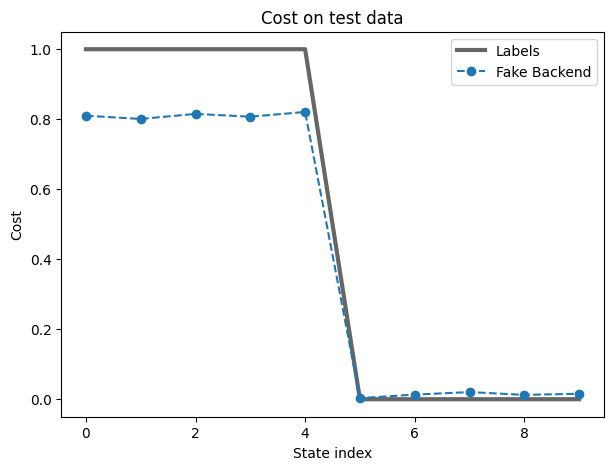

In [51]:
estimator = Estimator(mode=fake_backend)
estimator.options.default_shots = 5000
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

opt_params = np.load(r"C:\Users\Rajat\Downloads\opt_params_shallow_VQC.npy") # Load optimal parameters
results_test = test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm)

print(f"Performance: {compute_performance(results_test, list_labels)}")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')
ax.plot(results_test, 'o--', label='Fake Backend')
ax.legend()

In [53]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True)
print(backend.name)

ibm_brisbane


In [59]:
def test_shallow_VQC_QPU(list_labels, anstaz, obs, opt_params, options, backend):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels 
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Estimator options
        backend (service.backend): Backend to run the job 
        
    Returns:
        job_id (str): Job ID
    """

    estimator = Estimator(mode=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

    pubs = []
    for bird, label in enumerate(list_labels):
        ### Write your code below here ###
        qc = QuantumCircuit(num_qubits)
        amplitude_embedding(qc, bird)
        classifier = qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        ### Don't change any code past this line ###
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
                                           
    return job_id

In [60]:
resilience=0 
DD=False 
options_0=EstimatorOptions(default_shots=5000,
                           optimization_level=0,
                           resilience_level=resilience)
options_0.dynamical_decoupling.enable=DD 
options_0.dynamical_decoupling.sequence_type="XpXm"

resilience=1
DD = True
options_1 = EstimatorOptions(default_shots = 5000, 
                        optimization_level=0, 
                        resilience_level=resilience)  
options_1.dynamical_decoupling.enable = DD
options_1.dynamical_decoupling.sequence_type = 'XpXm'

In [61]:

def retrieve_job(job_id):

    ''' Retrieve results from job_id '''

    job = service.job(job_id)

    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(result.data.evs))
        errors_test.append(abs(result.data.stds))

    return results_test, errors_test

In [62]:
## No DD, no TREX (no ZNE)
job_id_0 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_0, backend)

## DD + TREX (no ZNE)
job_id_1 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_1, backend)

CircuitError: "Circuit args must be Registers or integers. (['QuantumCircuit'] '(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002CB4F076150>,)' was provided)"